# How Bi-Persistence Clustering Works

`biperscan` adapts HDBSCAN\* to extract clusters from bi-filtrations over a
distance scale and a centrality scale (other lens-dimensions are untested but
might work as well). This type of clustering is particularly useful for
detecting (lower-density) branches in a datasets. Such branches are difficult to
detect with clustering algorithms because they are connected to a central core
through short distances. In other words, there is no gap or low-density region
separating the branches and the central core. Hierarchical and density-based
clustering algorithms rely on such a gap to detect clusters, and therefore
struggle to detect branches.

A bi-filtration effectively introduces a gap between the branches by filtering
out central points with a varying centrality threshold, allowing the branches to
be detected as separate connected components (i.e., clusters).

While `biperscan` is implemented to be fast, it does not scale nicely with data
size. For practical applications, we instead recommend
[pyflasc](https://github.com/vda-lab/pyflasc): our more efficient branch &
cluster detection algorithm. The main difference between `biperscan` and
`pyflasc` is that `pyflasc` first extracts HDBSCAN\* clusters and then extracts
branches within the clusters, rather than trying to detect both at the same
time. This results in two fast filtrations instead of one expensive
bi-filtration.

In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from hdbscan import HDBSCAN
from biperscan import BPSCAN

from lib.drawing import plot_five_points_all, plot_five_points_minpres
from lib.plotting import *

palette = configure_matplotlib()

## The data

This example uses a noisy, 2D dataset from [pyflasc's
examples](https://vda-lab.github.io/pyflasc/How_FLASC_works.html), adapted from
[HDBSCAN\*'s soft clustering
tutorial](https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html).
One of the clusters has a Y-shape and contains three branches. These (kind of)
branches are not detected by HDBSCAN and other distance-based clustering
algorithms
([demo](https://vda-lab.github.io/pyflasc/Comparison_algorithms.html)).

c:\Users\lucp10736\Micromamba\envs\work\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lucp10736\Micromamba\envs\work\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


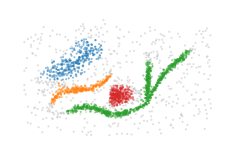

In [2]:
X = np.load("data/flared/flared_clusterable_data.npy")
scatter_kwargs = dict(s=1, alpha=0.5, linewidths=0, edgecolor="none")
color_kwargs = dict(
    cmap=ListedColormap(["silver"] + [f"C{i}" for i in range(10)]), vmin=-1, vmax=9
)

sized_fig(0.25)
plt.scatter(
    *X.T,
    c=HDBSCAN(min_samples=20, min_cluster_size=80).fit_predict(X),
    **scatter_kwargs,
    **color_kwargs,
)
plt.subplots_adjust(0, 0, 1, 1)
plt.axis("off")
plt.savefig("images/flareable_hdbscan_clusters.pdf", pad_inches=0)
plt.show()

BPSCAN is able to detect the branches as distinct clusters, but struggles to
generate a good labelling and is quite sensitive to the input parameters.

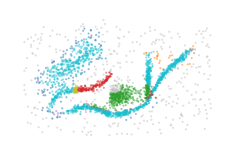

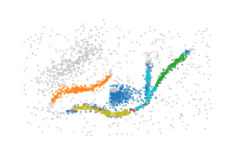

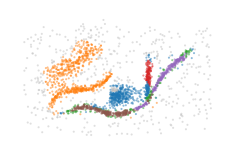

In [6]:
for k in [10, 30, 20]:
    c = BPSCAN(min_samples=k, min_cluster_size=80, distance_fraction=0.03).fit(X)

    sized_fig(0.25)
    plt.scatter(*X.T, c=c.labels_, **scatter_kwargs, **color_kwargs)
    plt.subplots_adjust(0, 0, 1, 1)
    plt.axis("off")
    plt.savefig(f"images/flareable_bpscan_clusters_{k}.pdf", pad_inches=0)
    plt.show()

## The BPSCAN algorithm

The remainder of this notebook explains how the BPSCAN algorithm works and is separated into sections: 

- [The centrality lens](#the-centrality-lens)
- [The minimal presentation](#the-minimal-presentation)
- [Extracting merges](#extracting-merges)
- [Simplifying merges](#simplifying-merges)
- [Labelling clusters](#labelling-clusters)

### The centrality lens

A centrality lens is used to detect branches in the bi-filtration. Effectively,
the process continually looks for clusters while increasing a centrality
threshold that allows more central points to enter the filtration. Initially, at
low thresholds, all central points are excluded, which separates the branches
from each other so they can be detected as clusters. As the centrality threshold
increases, the distance between the branches shrinks until they are detected as
a single cluster.

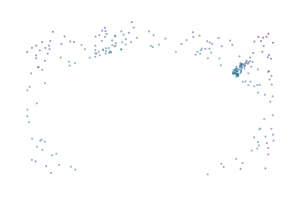

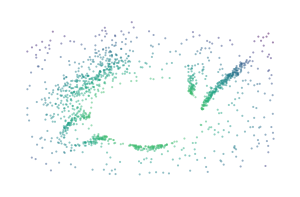

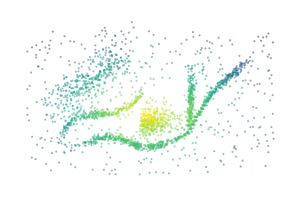

In [6]:
for i, threshold in enumerate([0.4, 0.7, 1.0]):
    sized_fig(0.33)
    mask = c.lens_values_ < threshold
    plt.scatter(
        *X[mask].T,
        c=c.lens_values_[mask],
        cmap="viridis",
        vmin=0,
        vmax=1,
        **scatter_kwargs
    )
    plt.subplots_adjust(0, 0, 1, 1)
    plt.axis("off")
    plt.savefig(f"images/flareable_centrality_threshold_{i}.pdf", pad_inches=0)
plt.show()

Biperscan supports three centrality lenses:

- negative_distance_to_mean
- negative_distance_to_median
- negative_eccentricity

Only the `negative_eccentricity` works with precomputed distances.

### The minimal presentation

Where hierarchical clustering extract clusters from a *minimum spanning tree*,
multi-parameter persistence works with *minimal presentations*. The idea is the
same: minimum presentations contain all topology changing edges in a
bi-filtration (we only consider 0-dimensional persistence, so edges are the
highest dimensional simplex we use). Because the bi-filtration considers two
parameters, minimal presentations typically contain more than N-1 edges.

As example, consider five points that lie on the corners and center of a
rectangle. A bi-filtration needs to consider all edges between the points, but
only a few of those edges are the first to connected points together. These
latter edges form the minimal presentation!

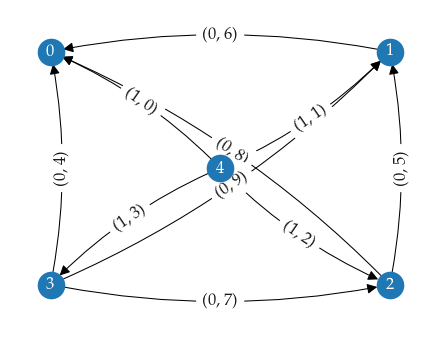

In [7]:
sized_fig(0.5, aspect=0.75)
plot_five_points_all()
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("images/five_points_all.pdf", pad_inches=0)
plt.show()

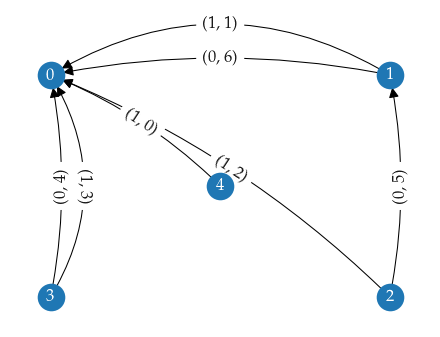

In [8]:
sized_fig(0.5, aspect=0.75)
plot_five_points_minpres()
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("images/five_points_minpres.pdf", pad_inches=0)
plt.show()

The minimal presentation for the noisy data shows why the noise points are
tricky. The repeated edges, which occur between ancestors connected to multiple
other points, lie between the most eccentric (noise) points.

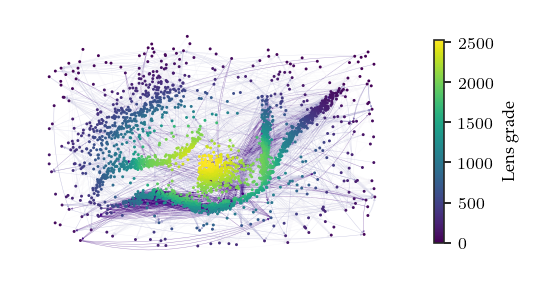

In [7]:
minpres = c.minimal_presentation_

sized_fig(0.5)
minpres.plot_network(
    layout={i: (c[0], c[1]) for i, c in enumerate(X)},
    labels=False,
    node_kws=dict(node_size=2, edgecolors="none", linewidths=0),
    line_kws=dict(width=0.2, arrowsize=2, alpha=0.5, edge_vmin=0, edge_vmax=100000),
)
plt.subplots_adjust(0, 0, 1.2, 1)
plt.savefig('images/flareable_minimal_presentation_network.png', pad_inches=0)
plt.show()

Another way to view the minimal presentation is through the range of
lens--distance grades data points are *alive*. The edges in the minimal
presentation represent when the child *dies* into the parent. So, we can draw a
curve for each point, indicating at which grades it merges with a parent. The
area under these curves, represents the persistence of the data points.
Meaningfully combining lens and distance values is tricky, as they do not
necessarily relate to each other.

Visually, the lens--distance plot is not very informative, but it does indicate
that most points merge at very low distance grades.

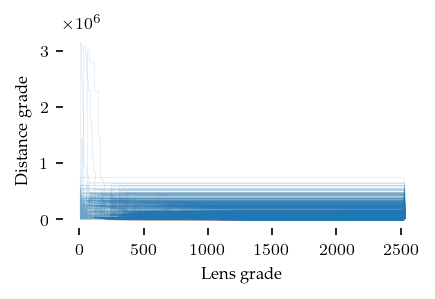

In [8]:
sized_fig(0.5)
minpres.plot_persistence_areas(
    line_kws=dict(alpha=0.1, linestyle="-", linewidths=0.5)
)
plt.subplots_adjust(0.13, 0.23, 1, 1)
plt.savefig("images/flareable_persistence_areas.png", pad_inches=0)
plt.show()

### Extracting merges

The next step for adapting HDBSCAN would be to convert the minimal presentation
into a linkage hierarchy, which would then be simplified using a minimum cluster
size threshold to produce a condensed cluster tree. 

It turns out that extracting merges between clusters with a minimum size is
easier when done on the minimal presentation directly, rather than a bi-graded
linkage hierarchy. We do provide code that computes such linkage hierarchies,
but do not use the hierarchy in the BPSCAN algorithm. Bi-graded linkage
hierarchies are considerably larger than the minimal presentation they originate
from because they enumerate all data-point combinations that exist throughout
the bi-filtration, making them more expensive to create and work with. Minimal
presentations encode many of these combinations implicitly.

To explain how we extract merges, we first need to explain how minimal
presentations are represented. Minimal presentations are constructed in the form
of a (boundary) matrix. In our case, rows represent data points (ordered with
increasing lens grade) and columns represent edges (ordered with
lexicographically increasing bi-grades). The image below shows a small 
minimal presentation with its boundary matrix. The 1s indicate which points
are connected in each column.

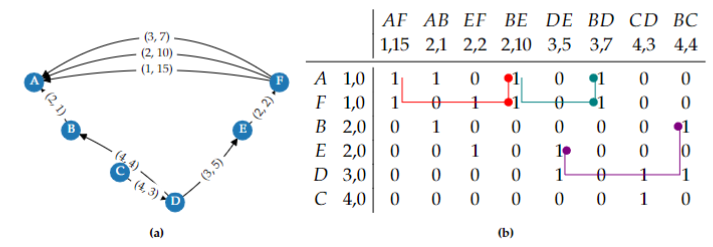

To extract the merges, we look for columns with the same child point. These
columns represent two edges connected to the one point: one to each (potential)
cluster connected through the child point. It makes sense to look at child
points because relatively central points that shrink the distance between
branches are always encoded as child. There are three column pairs with
this pattern in the example minimal presentation. One connecting different
parent points and two connecting to the same parent points. Finding these column
pairs is easy, by traversing the minimal presentation from left to right and
storing the previous column seen for each child point. 

To check whether these edges merge clusters at the given minimum cluster size,
we need to figure out if the sides of the merge connect to enough other points
before connecting to each other. For this purpose we interpret the matrix as an
undirected graph, facilitating traversal. In the case indicated by violet lines,
we consider all edges with bi-grade lower than $(4, 5)$, the grade induced by
the selected columns. Then, we perform a set-symmetric-difference-like iteration
that traverses from the parent with the lowest distance edge and collects all
points connected to it within that distance. The iteration stops when one side
connects to a point already contained by the other side or when both sides do
not have any edges remaining. The child point is excluded from the traversal, as
it would be found by both sides immediately, thereby stopping the iteration. A
merge is stored if both sides have reached the minimum cluster size when
traversal stops.

For column pairs with matching parents (red and teal lines), we traverse from
the parent and child points instead. In the example shown above, three merges
would be found with a minimum cluster size of two points:

- (2, 10) {A, B}, {F, E}
- (3,  7) {A, B}, {F, E, D}
- (4,  5) {A, B}, {F, E}

On noisy data sets, it can be beneficial to set an upper distance bound for the
traversal to exclude noisy points. Below are the selected merges found for the
noisy data example:

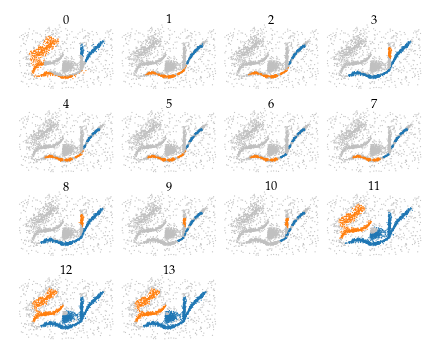

In [11]:
sized_fig(0.5, aspect=0.8)
merges = c.merges_
merges.plot_merges(*X.T, s=0.33, title_y=0.8, arrowsize=3, linewidth=0.5)
plt.subplots_adjust(0, 0, 1, 0.975, wspace=0)
plt.savefig("images/flareable_merges.png", pad_inches=0)
plt.show()

The merges are ordered lexicographically and can be plotted on the
distance--centrality parameter plane:

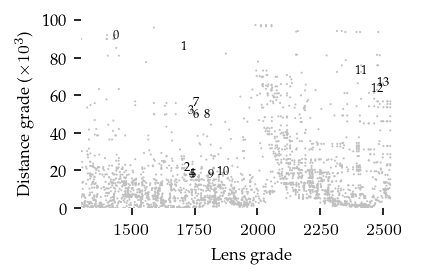

In [12]:
sized_fig(0.5)
merges.plot_persistence_areas()
plt.subplots_adjust(0.12, 0.17, 1, 0.97)
plt.yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels([f"{int(v/1000)}" for v in plt.gca().get_yticks()])
plt.xlim(1300, plt.xlim()[1])
plt.ylabel("Distance grade ($\\times 10^3$)")
plt.subplots_adjust(0.17, 0.23, 1, 0.97)
plt.savefig("images/flareable_merge_hierarchy.png", pad_inches=0)
plt.show()

All clusters and branches are detected by at least one merge in this example,
indicating the bi-filtration is able to detect both patterns. However,
extracting a cluster labelling from these merges is still tricky, as there
appear to be several (near) duplicates for each merge.

### Combining merges

In an effort to detect which merges are (near) duplicates, we iterate over the
merges in reverse order and combine visited merges if both the parent and child
root are included in the current parent and child side respectively. This
process reduces the number of (near duplicates), but does not remove all
membership overlap.

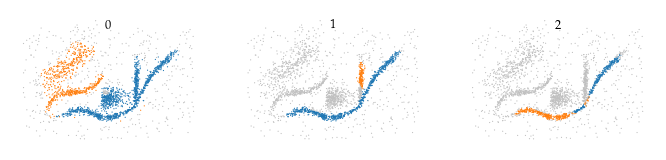

In [13]:
sized_fig(1, 0.618/3)
simplified_merges = c.simplified_merges_
simplified_merges.plot_merges(*X.T, s=0.33, title_y=0.8, arrowsize=3, linewidth=0.5, n_rows=1, n_cols=3)

The figure below indicates which bi-grades were combined:

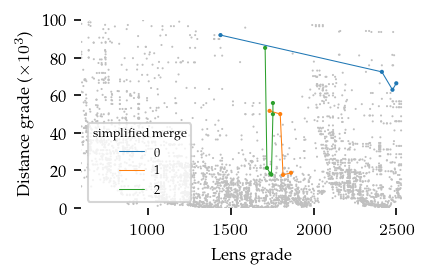

In [14]:
sized_fig(0.5)
simplified_merges.plot_persistence_areas()
plt.yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels([f"{int(v/1000)}" for v in plt.gca().get_yticks()])
plt.xlim(600, plt.xlim()[1])
plt.ylabel("Distance grade ($\\times 10^3$)")
plt.subplots_adjust(0.17, 0.23, 1, 0.97)
plt.savefig("images/flareable_simplified_hierarchy.png", pad_inches=0)
plt.show()

### Labelling clusters

The final step is to convert the simplified merges into cluster labels. This is
done by first creating a num. points by num. groups membership matrix from the
simplified merges. Then, points are labelled by the unique membership
combinations present in the matrix. This combinatorial labelling can result in
many labels when the detected merges do not simplify into few simplified merges!

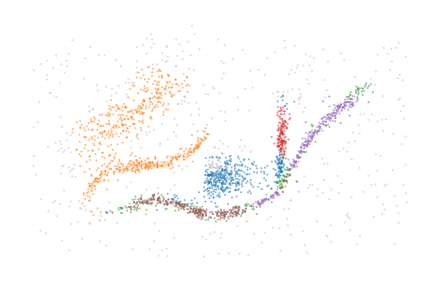

In [15]:
sized_fig(0.5)
plt.scatter(*X.T, c=c.labels_, **scatter_kwargs, **color_kwargs)
plt.subplots_adjust(0, 0, 1, 1)
plt.axis("off")
plt.show()

Alternatively, the membership vectors can be used for further downstream processing. For example, they can be projected to colors using the CIELAB colorspace:

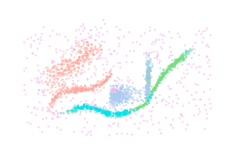

In [17]:
from sklearn.manifold import MDS
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color


def map_to_cielab(values):
    # Scale primary dimension to be within 0-100
    # Translate other dimensions to be around 0
    i = np.min(values[:, 0], axis=0)
    a = np.max(values[:, 0], axis=0)

    scaled = np.empty((values.shape[0], 3), dtype=np.float64)
    scaled[:, 0] = 80
    scaled[:, 1:] = (values - i) / (a - i) * 100
    scaled[:, 1:] -= np.mean(scaled[:, 1], axis=0)

    # Interpret as CIELAB and convert to RGB
    rgbs = []
    for i in range(len(scaled)):
        rgb = convert_color(
            LabColor(scaled[i, 0], scaled[i, 1], scaled[i, 2]), sRGBColor
        )
        rgbs += [(rgb.clamped_rgb_r, rgb.clamped_rgb_g, rgb.clamped_rgb_b)]
    return rgbs, scaled


mapping = MDS(n_components=2).fit_transform(c.membership_)
rgbs, scaled = map_to_cielab(mapping)

sized_fig(0.25)
plt.scatter(*X.T, c=rgbs, **scatter_kwargs)
plt.subplots_adjust(0, 0, 1, 1)
plt.axis("off")
plt.savefig('images/flareable_membership_colors.pdf', pad_inches=0)
plt.show()